<a href="https://colab.research.google.com/github/anushpittu/Naturallanguageprocessing/blob/main/XLNet_on_20_Newsgroups_and_contextual_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **Challenge:**

Perform Text classification using XLNet on 20 Newsgroups and apply the Contextual augmentation. Report the performance metrics for before and after augmentation? show examples of data augmentaion?

# Text classification using XLnet

In [1]:
#Let's start by importing some libraries

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 22.3MB/s 
     |████████████████████████████████| 3.3MB 39.1MB/s 
     |████████████████████████████████| 870kB 52.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e663f34fbff4898c57282c61a529f312693573f5cdd237f93318325031cff6c3
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
import torch
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification
from transformers.models.xlnet.modeling_xlnet import XLNetForSequenceClassificationOutput
from transformers import Trainer, TrainingArguments
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn import metrics

In [4]:
# set seed for reproducability
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [5]:
model_name = "xlnet-base-cased"
tokenizer = XLNetTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [6]:
#Since there are limited resources we cannot use all the categories considering the size of the file so using only part of it for both training and augmentation
cats = ['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.misc']

In [7]:
#we can get the full data  set just by changing the categories = cats to 'None'
newsgroups_train = fetch_20newsgroups(subset = 'train',shuffle = True,random_state = 0, categories = cats, remove=("headers", "footers", "quotes"))
newsgroups_test= fetch_20newsgroups(subset = 'test',shuffle = True,random_state = 0, categories = cats, remove=("headers", "footers", "quotes"))

In [8]:
#shape of the data
newsgroups_train.filenames.shape

(2137,)

In [9]:
#shape of the target data
newsgroups_train.target.shape

(2137,)

In [10]:
pprint(list(newsgroups_train.target_names))
#print the final list of target names

['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.misc']


In [11]:
#alloting the train data and its target to x and y
X_train = newsgroups_train.data
y_train = newsgroups_train.target

In [12]:
#alloting the test data and its target 
X_test = newsgroups_test.data
y_test = newsgroups_test.target

In [13]:
print("X_train is of type: ",type(X_train))
print("y_train is of type: ",type(y_train))

X_train is of type:  <class 'list'>
y_train is of type:  <class 'numpy.ndarray'>


In [14]:
 # tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

In [15]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, y_train)
valid_dataset = NewsGroupsDataset(valid_encodings, y_test)

In [16]:
# load the model and pass to CUDA
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=len(newsgroups_train.target_names)).to("cuda")

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [17]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = metrics.accuracy_score(labels, preds)
  f1score = metrics.f1_score(labels,preds, average='macro')
  return { 'accuracy': acc,  'f1_score': f1score}

In [18]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [19]:
trainer.train()

Step,Training Loss
500,0.521200


TrainOutput(global_step=804, training_loss=0.40040313663767346, metrics={'train_runtime': 1477.5026, 'train_samples_per_second': 0.544, 'total_flos': 2310412055482368.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 724992, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 16670720, 'train_mem_gpu_alloc_delta': 1438158336, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 7634620416})

In [20]:
# evaluate the current model after training
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.7874736101337086,
 'eval_f1_score': 0.7804894132496232,
 'eval_loss': 0.9851990938186646,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 970181120,
 'eval_runtime': 165.8575,
 'eval_samples_per_second': 8.568}

Now that we have performed text classification using XLnet
The results are as follows
> * 'eval_accuracy' :  0.7874736101337086

In [21]:
test = """
A black hole is a place in space where gravity pulls so much that even light can not get out. 
The gravity is so strong because matter has been squeezed into a tiny space. This can happen when a star is dying.
Because no light can get out, people can't see black holes. 
They are invisible. Space telescopes with special tools can help find black holes. 
The special tools can see how stars that are very close to black holes act differently than other stars.
"""

In [22]:
def prediction(test):
  inputs = tokenizer(test, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
  outputs = model(**inputs)
  probs = outputs[0].softmax(1)
  return newsgroups_train.target_names[probs.argmax()]

print("predicted cateogry of test: ",prediction(test))

predicted cateogry of test:  sci.space


#Data augmentation

The analogy to deep learning is that the rocket engine is the deep learning models and the fuel is the huge amounts of data we can feed to these algorithms. — Andrew Ng

Incase where there is a imbalance in between the target variables the data augmentation methods can be used to balance the data

Although there are many methods for doing data augmentation such as EDA(easy data augmentation) and back translation

Now, lets use a python package called "NLPaug"


With NLPaug we can choose non-contextual embeddings or contextual ones as well

In [23]:
!pip install nlpaug

     |████████████████████████████████| 399kB 14.6MB/s 


In [24]:
#lets import libraries
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

In [25]:
Original = 'The quick brown fox jumps over the lazy dog'

In [26]:
##Random Character Augmentation which is a type of character augmentation

In [27]:
randaug = nac.RandomCharAug(action="insert")
augmented_text = randaug.augment(Original)
print("Original Text: ", Original)
print("Augmented Text:", augmented_text)

Original Text:  The quick brown fox jumps over the lazy dog
Augmented Text: The qufick brown fox jumps over the lRazy dog


In [28]:
##Spelling augmentation which is a type of word augmentation

In [29]:
spellingaug = naw.SpellingAug()
augmented_text = spellingaug.augment(Original, n=3)
print("Original:", Original)
print("Augmented Texts:", augmented_text)

Original: The quick brown fox jumps over the lazy dog
Augmented Texts: ['Them quick brown fox jumps over the leazy dog', 'Tne quick brown fox jumps overt the lazy dog', 'The qchick brown fox jumps over the lazy djg']


In [30]:
#Keyboard augmentation which is a type of character augmentation

In [31]:
keyboardaug = nac.KeyboardAug()
augmented_text = keyboardaug.augment(Original)
print("Original Text: ", Original)
print("Augmented Text:", augmented_text)

Original Text:  The quick brown fox jumps over the lazy dog
Augmented Text: The quick bgown fox jumps ov#r the lazy dog


In [32]:
#Random word augmenation which is a part of word augmentation

In [33]:
randomaug = naw.RandomWordAug()
augmented_text = randomaug.augment(Original)
print("Original Text: ", Original)
print("Augmented Text:", augmented_text)

Original Text:  The quick brown fox jumps over the lazy dog
Augmented Text: The quick fox jumps over lazy dog


# Augmentation on our data set

Now coming back to our original challenge. Lets perform contextual augmenation on the given data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


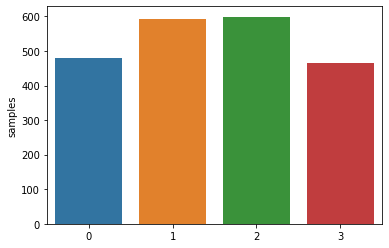

In [34]:
#lets first see the count of each target value
unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(unique, counts)
plt.gca().set_ylabel('samples');

In [35]:
#and lets find out how many of them are less than a number say 550
categories_less_than_550 = unique[counts<550].tolist()
categories_less_than_550

[0, 3]

In [36]:
#lets now find out the difference between the count of these targets and 550
difference = (550 - counts[categories_less_than_550]).tolist()
difference

[70, 85]

In [37]:
#import the xlnet contextual embedding
aug = naw.ContextualWordEmbsAug(model_path='xlnet-base-cased', model_type='xlnet',device = 'cuda')

In [38]:
X_augmented_train =X_train
y_augmented_train = y_train

In [39]:
print(len(X_augmented_train))

2137


In [40]:
print(len(y_augmented_train))

2137


In [41]:
  augmentation_text_list = []
  augmentation_index_list = []

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

torch.cuda.empty_cache()

In [42]:
for ii in range(0,len(categories_less_than_550)):
    result = [jj for jj, val in enumerate(y_augmented_train==categories_less_than_550[ii]) if val]
    for kk in range(0,difference[ii]):
      index = random.choice(result)
      text = X_augmented_train[index]
      aug.device = 'cuda'
      augmented_data = aug.augment(text)
      augmentation_text_list.append(augmented_data)
      augmentation_index_list.append(categories_less_than_550[ii])

In [43]:
y_augmented_train = y_augmented_train.tolist()

In [44]:
type(y_augmented_train)

list

In [45]:
  X_augmented_train.extend(augmentation_text_list)
  y_augmented_train.extend(augmentation_index_list)

In [46]:
print(len(X_augmented_train))

2292


In [47]:
print(len(y_augmented_train))

2292


In [48]:
train_encodings = tokenizer(X_augmented_train, truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

In [49]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, y_augmented_train)
valid_dataset = NewsGroupsDataset(valid_encodings, y_test)

In [50]:
# load the model and pass to CUDA
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=len(newsgroups_train.target_names)).to("cuda")

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [51]:
from sklearn import metrics

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = metrics.accuracy_score(labels, preds)
  f1score = metrics.f1_score(labels,preds, average='macro')
  return { 'accuracy': acc,  'f1_score': f1score}

In [52]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [53]:
trainer.train()

Step,Training Loss
500,0.578300


TrainOutput(global_step=861, training_loss=0.4340455678835702, metrics={'train_runtime': 1577.138, 'train_samples_per_second': 0.546, 'total_flos': 2477989906956288.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -94195712, 'train_mem_gpu_alloc_delta': 1437933056, 'train_mem_cpu_peaked_delta': 95997952, 'train_mem_gpu_peaked_delta': 7627505664})

In [54]:
# evaluate the current model after training
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.7923997185080929,
 'eval_f1_score': 0.7820251117891948,
 'eval_loss': 1.054348111152649,
 'eval_mem_cpu_alloc_delta': 163840,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 894673920,
 'eval_runtime': 164.4913,
 'eval_samples_per_second': 8.639}

Now that we have performed text classification using XLnet
The results are as follows
> * 'eval_accuracy' :   0.7923997185080929

Accuracy score comparison:

>  Before augmentation :   0.7874736101337086         
>  After augmentation    :   0.7923997185080929

# Final thoughts

Considering the fact that we have trained the data set on the limited set of categories and the fact the we have used augmentation only limited number of times because of the limited set of resources, the improvement of accuracy shows us that Data augmentation works to improve accuracy